In [1]:
import pandas as pd
import fitparse
import numpy as np
import matplotlib
import pprint as pp

In [2]:
# Create a list of file locations
files = [
    "Mother_North_day_1.fit",
    "Mother_North_day_2a.fit",
    "Mother_North_day_2b.fit",
    "Mother_North_day_3a.fit",
    "Mother_North_day_3b.fit",
    "Mother_North_final_push.fit"
]

# Create a function that will parse one .fit file at a time
def parse_file(file):
    data = []
    fitfile = fitparse.FitFile(file)
    for record in fitfile.get_messages("record"):
        data.append(record.get_values())
    return data

# Create a loop that will parse all files in the files list
all_data = []
for file in files:
    data = parse_file(f"../data/raw/original/{file}")
    all_data = all_data + data


In [3]:
# Create a pandas dataframe
df = pd.DataFrame(all_data)
df.sort_values(by="timestamp", inplace=True)

# Verify that the parsing worked as expected
df.head()

,timestamp,distance,calories,battery_soc,position_lat,position_long,enhanced_altitude,altitude,enhanced_speed,speed,grade,vertical_speed,ascent,descent,power,heart_rate,cadence,temperature,left_right_balance,gps_accuracy
0,2024-08-11 07:00:22,0.0,0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-08-11 07:00:23,0.0,0,100.0,729232816.0,124940754.0,267.6,267.6,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-08-11 07:00:24,0.0,0,NaN,729232816.0,124940754.0,267.6,267.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,NaN,NaN,NaN
3,2024-08-11 07:00:25,0.0,0,NaN,729233408.0,124940880.0,267.6,267.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0,NaN,NaN,NaN
4,2024-08-11 07:00:26,0.0,0,NaN,729233499.0,124940902.0,267.6,267.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,0.0,21.0,NaN,NaN


In [4]:
# Check data types
df.dtypes

timestamp             datetime64[ns]
distance                     float64
calories                       int64
battery_soc                  float64
position_lat                 float64
position_long                float64
enhanced_altitude            float64
altitude                     float64
enhanced_speed               float64
speed                        float64
grade                        float64
vertical_speed               float64
ascent                       float64
descent                      float64
power                        float64
heart_rate                   float64
cadence                      float64
temperature                  float64
left_right_balance           float64
gps_accuracy                 float64
dtype: object

In [5]:
# Create an empty dictionary to store the units of measurement data
unit_dict = {}

# Parse only the first fit file in the list of files, as the units will be the same for all
fitfile = fitparse.FitFile(f"../data/raw/anthony/{files[0]}")

# Loop through the record and update the unit_dict with the field name and unit of measurement
for record in fitfile.get_messages("record"):
    for record_data in record:
        unit_dict.update({record_data.name: record_data.units})

# Print unit_dict to verify the data was collected as expected
pp.pprint(unit_dict)

{'altitude': 'm',
 'ascent': 'm',
 'battery_soc': 'percent',
 'cadence': 'rpm',
 'calories': 'kcal',
 'descent': 'm',
 'distance': 'm',
 'enhanced_altitude': 'm',
 'enhanced_speed': 'm/s',
 'grade': '%',
 'heart_rate': 'bpm',
 'left_right_balance': None,
 'position_lat': 'semicircles',
 'position_long': 'semicircles',
 'power': 'watts',
 'speed': 'm/s',
 'temperature': 'C',
 'timestamp': None,
 'vertical_speed': 'm/s'}


In [6]:
# List the numner of null values for each column
df.isna().sum()

timestamp                  0
distance                   2
calories                   0
battery_soc           184172
position_lat             654
position_long            654
enhanced_altitude         99
altitude                  99
enhanced_speed           654
speed                    654
grade                    100
vertical_speed         62770
ascent                   100
descent                  100
power                   3236
heart_rate              1083
cadence                  812
temperature               14
left_right_balance     19911
gps_accuracy          122174
dtype: int64

In [7]:
# Drop the columns that will not provide any value to the analysis
cols_to_drop = [
    "calories",
    "battery_soc",
    "left_right_balance",
    "gps_accuracy",
    "enhanced_altitude",
    "enhanced_speed"
]

df.drop(columns=cols_to_drop, inplace=True)

# Fill missing temperature values using bfill and then ffill
df["temperature"] = df.temperature.bfill().ffill()

# Drop duplicate rows where the coordinates have not changed - i.e. stationary moments
df = df.drop_duplicates(subset=["position_lat", "position_long"], keep="first").copy()

# Fill null values for coordinates and altitude using linear interpolation
df['position_lat'] = df['position_lat'].interpolate(method='linear')
df['position_long'] = df['position_long'].interpolate(method='linear')
df['altitude'] = df['altitude'].interpolate(method='linear')

# Drop the first row that wasn't filled during interpolation
df = df.dropna(subset=["position_lat"]).copy()

df.isna().sum()

timestamp             0
distance              0
position_lat          0
position_long         0
altitude              0
speed                 0
grade                75
vertical_speed    62119
ascent               75
descent              75
power              3066
heart_rate         1027
cadence             797
temperature           0
dtype: int64

<Axes: xlabel='position_long', ylabel='position_lat'>

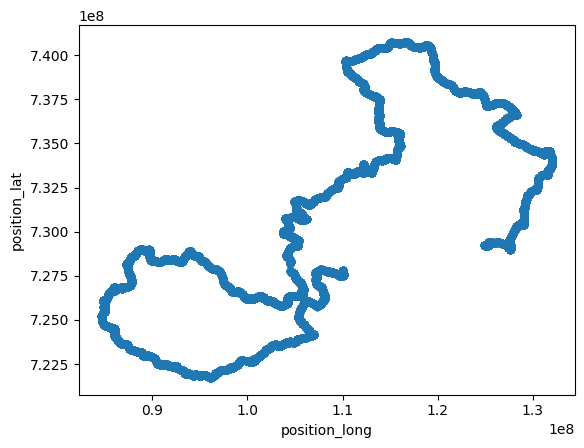

In [8]:
# Plot the coordinates on a scatterplot to do a quick visual confirmation of the location data.
# The shape of the route looks correct and the missing data is represented as a gap.
df.plot.scatter(x="position_long", y="position_lat")

#### Load supplementary data:
Load and check the supplementary data from the other fit file and append it to the main dataframe.

In [9]:
# Parse the other riders .fit file
file = "../data/raw/supplementary/supplementary.fit"
fitfile_sup = parse_file(file)
df_sup = pd.DataFrame(fitfile_sup)

# Rename columns to match main dataframe
df_sup.rename({"enhanced_altitude": "altitude"}, axis=1, inplace=True)

# Drop duplicate rows where the coordinates have not changed - i.e. stationary moments
df = df.drop_duplicates(subset=["position_lat", "position_long"], keep="first").copy()

In [10]:
# Drop the rows that are not required - i.e. those that match time periods already covered by the main dataframe.

# Find the last timestamp in the main dataframe.
last_entry = df.timestamp.max()
print(last_entry)

# Create a new dataframe that excludes the unnecessary data and keep only the necessary columns.
extended_data = df_sup.loc[df_sup.timestamp > last_entry][["timestamp", "position_lat", "position_long", "distance", "altitude", "temperature"]]

# Check for null values.
extended_data.isna().sum()

2024-08-14 11:03:02


timestamp        0
position_lat     0
position_long    0
distance         0
altitude         0
temperature      0
dtype: int64

<Axes: xlabel='position_long', ylabel='position_lat'>

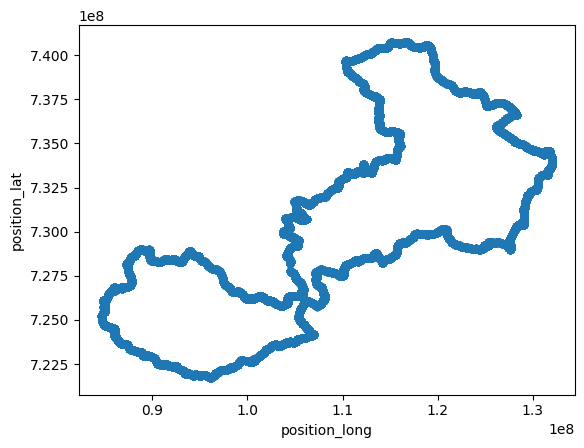

In [12]:
# Concatenate the main dataframe and the extended data
joined = pd.concat([df, extended_data]).reset_index(drop=True)

# Check the route again using a scatterplot
joined.plot.scatter(x="position_long", y="position_lat")

<Axes: xlabel='timestamp'>

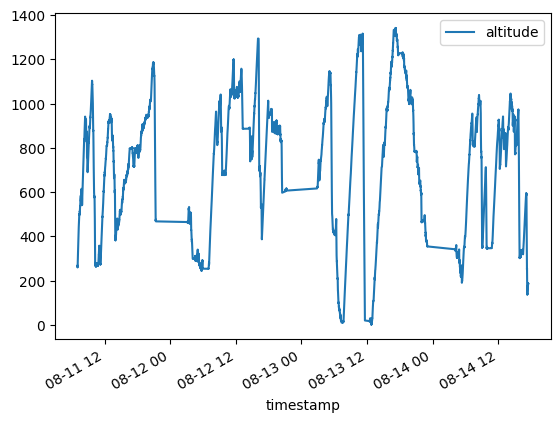

In [13]:
# Create a line chart to check the elevation profile.
joined.plot.line(x="timestamp", y="altitude")

In [14]:
# Create a function to convert semicircles to degrees
def semicircles_to_degrees(semicircles):
    return semicircles * (180 / 2**31)

# Create a function that uses the haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):

    # Earth's radius in meters
    R = 6371000
    
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in meters
    return R * c

# Convert latitude and longitude from semicircles to degrees
joined['latitude_deg'] = semicircles_to_degrees(joined['position_lat'])
joined['longitude_deg'] = semicircles_to_degrees(joined['position_long'])

# Calculate distance between consecutive points and fill NaN for the first row with 0 (no previous point to calculate distance from)
joined['distance_increment'] = haversine(joined['latitude_deg'], joined['longitude_deg'], joined['latitude_deg'].shift(), joined['longitude_deg'].shift())
joined["distance_increment"] = joined["distance_increment"].fillna(0)

# Calculate cumulative distance
joined['distance'] = joined['distance_increment'].cumsum()

In [15]:
joined.describe()

,timestamp,distance,position_lat,position_long,altitude,speed,grade,vertical_speed,ascent,descent,power,heart_rate,cadence,temperature,latitude_deg,longitude_deg,distance_increment
count,206241,2.062410e+05,2.062410e+05,2.062410e+05,206241.000000,183431.000000,183356.000000,121312.000000,183356.000000,183356.000000,180365.000000,182404.000000,182634.000000,206241.000000,206241.000000,206241.000000,206241.000000
mean,2024-08-13 00:31:57.866704384,5.245364e+05,7.299987e+08,1.078111e+08,726.876819,4.880930,2.240142,0.003646,1972.356749,1645.784239,133.983384,116.696043,60.490380,13.593519,61.187783,9.036620,4.911955
min,2024-08-11 07:00:23,0.000000e+00,7.217109e+08,8.463298e+07,0.800000,0.000000,-35.830000,-2.058000,0.000000,0.000000,0.000000,59.000000,0.000000,3.000000,60.493111,7.093854,0.000000
25%,2024-08-12 04:18:14,2.820959e+05,7.263520e+08,9.875575e+07,474.600000,2.393000,0.000000,0.000000,717.000000,529.000000,107.000000,109.000000,50.000000,11.000000,60.882118,8.277612,2.339100
50%,2024-08-13 03:55:24,5.356007e+05,7.289263e+08,1.079253e+08,785.000000,4.304000,1.510000,0.066000,1810.000000,1415.000000,145.000000,116.000000,68.000000,13.000000,61.097893,9.046190,4.153532
75%,2024-08-13 20:36:02,7.703207e+05,7.339486e+08,1.159813e+08,945.200000,6.535000,5.740000,0.133000,3209.000000,2932.000000,174.000000,124.000000,80.000000,16.000000,61.518860,9.721443,6.532597
max,2024-08-14 17:31:07,1.013046e+06,7.407650e+08,1.320449e+08,1341.600000,21.168000,32.810000,0.562000,4538.000000,4385.000000,474.000000,165.000000,172.000000,42.000000,62.090202,11.067874,4071.555330
std,NaN,2.878633e+05,5.018728e+06,1.326513e+07,305.397011,3.037402,4.823714,0.227263,1387.619203,1219.282549,65.233933,14.241957,27.596878,4.296787,0.420665,1.111870,10.181918


In [16]:
# Create time_increment, speed and elevation_increment columns
joined["time_increment"] = (joined.timestamp - joined.timestamp.shift()).dt.seconds.fillna(0)
joined["elevation_increment"] = (joined.altitude - joined.altitude.shift()).fillna(0)

# Recalculate speed, ascent, descent and grade
joined["speed"] = (joined.distance_increment / joined.time_increment).fillna(0)
joined["ascent"] = joined['elevation_increment'].where(joined['elevation_increment'] > 0, 0).cumsum()
joined["descent"] = joined['elevation_increment'].where(joined['elevation_increment'] < 0, 0).cumsum()
joined["grade"] = (joined.elevation_increment.rolling(10).sum() / joined.distance_increment.rolling(10).sum() * 100).bfill()

# Find grade values lower than -30 and higher than 30, and replace them with -30 and 30 respectively
joined.loc[joined.grade > 30, 'grade'] = 30
joined.loc[joined.grade < -30, 'grade'] = -30

# Recalculate vertical_speed
joined["vertical_speed"] = (joined["grade"] / 100) * (joined.distance_increment.rolling(10).sum() / joined.time_increment.rolling(10).sum()).bfill()
joined.isna().sum()

timestamp                  0
distance                   0
position_lat               0
position_long              0
altitude                   0
speed                      0
grade                      0
vertical_speed             0
ascent                     0
descent                    0
power                  25876
heart_rate             23837
cadence                23607
temperature                0
latitude_deg               0
longitude_deg              0
distance_increment         0
time_increment             0
elevation_increment        0
dtype: int64

In [ ]:
# Export the dataframe to a .csv file for use in the first machine learning notebook
joined.to_csv("../data/clean/cleaned.csv", index=False)